# **Caso de estudio - Redes neuronales**

Por: 
- Juan E. Soto 
- Paola A. Arabia 
- Santiago Restrepo 
- Alanis Álvarez,

# **Descripción del problema de negocio**

Hoy en día, muchas organizaciones dependen del procesamiento manual para transcribir los dígitos escritos a mano en formularios físicos a bases de datos digitales. La empresa swift de desarrollo de software busca crear una solución de reconocimiento automático de dígitos que son manuscritos para un sistema de digitalización de formularios ya que este proceso es propenso a errores humanos y consume una gran cantidad de tiempo, por lo que implementar un sistema automatizado de reconocimiento de dígitos puede aumentar la eficiencia operativa, reduciendo el tiempo que le toma a los empleados transcribir manualmente digitos en formularios, además que la empresa se enfrenta a un volumen creciente de datos que se deben digitalizar.

# **Diseño de solución propuesto**

Para abordar el problema expuesto anteriormente, se propone un sistema automatizado de reconocimiento de dígitos manuscritos basado en un modelo de redes neuronales. Este modelo de aprendizaje automático será capaz de identificar y transcribir automáticamente los dígitos escritos a mano en formularios físicos, digitalizando estos datos con alta precisión. Con esta propuesta, se espera reducir los errores manuales de transcripción, garantizando que los datos digitalizados sean precisos y confiables.

Se utilizará una base de datos de imágenes del conjunto de datos 'mnist' de Keras, para posteriormente implementar redes neuronales, ya que estas tienen la capacidad de captar características espaciales y patrones de datos que se encuentran en las imágenes. Luego se ajustarán los hiperparámetros para mejorar su precisión, y se procederá a experimentar con diferentes estructuras de redes y técnicas de regularización para prevenir sobreajustes. Así, la empresa podrá integrar el sistema de digitalización de formularios de manera automática al ser escaneados, mejorando la eficiencia operativa y reduciendo significativamente el tiempo necesario para procesar formularios.



In [1]:
### Carga de paquetes y librerias
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

import pprint

import tensorflow as tf # Framework de deep learning
from tensorflow import keras # API que contiene la mayoría de funciones para las RN
import keras.datasets as datasets
from keras_tuner.tuners import RandomSearch


## Lectura de datos

Para este proyecto se hará uso de datos tipo imagen, y para ello se utiliza el conjunto de datos *'mnist'* de keras, el cual consiste en un conjunto de datos con imágenes con números del 0 al 9. Así mismo, cabe destacar que a este conjunto de datos no se le realiza ningún tipo de preprocesamiento ni manipulación dada la naturaleza de los mismos.





In [2]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

In [ ]:
X_train[2]

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

Como parte del análisis exploratorio, se observa que el conjunto de datos tiene una variable objetivo de tipo multiclase, ya que posee 10 diferentes valores como respuesta (números del 0 al 9). Adicionalmente, se evidencia que el dataset está medianamente balanceado dado que se cuenta con un número de observaciones similar en cada clase.

In [ ]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

Por otro lado, se cuenta con un total de 60.000 imágenes para entrenamiento y 10.000 imágenes para prueba, las cuales tienen una dimensión de 28 por 28 pixeles en escala de grises.

In [3]:
# Normalización de los datos
X_train_final = X_train/255 # Valores entre 0 y 1
X_test_final = X_test/255
X_train_final.shape, X_test_final.shape

((60000, 28, 28), (10000, 28, 28))

6

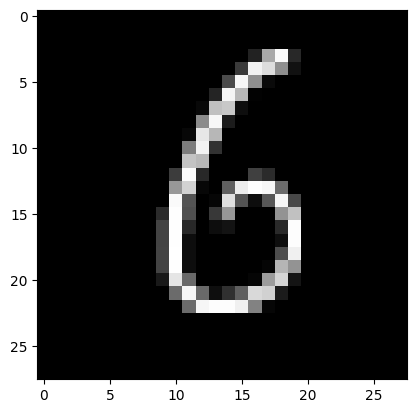

In [ ]:
plt.imshow(X_train[18], cmap='gray') #cmap en gray porque esta en escala de grises, observación 18
y_train[18]

# **1. Redes neuronales convolucionales**

Dado que se cuenta con un conjunto de datos con imágenes, se procede a ejecutar redes neuronales convolucionales ya que estas estan diseñadas para aprender automáticamente características importantes, como bordes, formas de un píxel, entre otros, con el fin de identificar y diferenciar entre objetos, y así, llegar a la red óptima que nos permita obtener predicciones precisas y coherentes.

## **1.1. Red neuronal convolucional base**

Inicialmente, se hace uso de una red neuronal convolucional con las siguinetes características:
- 1 capa convolucional en dos dimensiones con un total de 32 filtros de tamaño 3x3 con zancadas de 2x2 para imágenes de 28x28 píxeles en escala de grises.
- La respectiva capa de agrupación con un tamaño de 2x2 y zancadas de 2x2.
- 1 capa flatten (aplanamiento)
- 1 capa densa con 128 neuronas
- Su caoa de salida con sus respectivas 10 neuronas

In [ ]:
## Definición de la arquitectura CNN
model_cnn = keras.models.Sequential()

# Definición de la primera capa convolucional
model_cnn.add(
    keras.layers.Conv2D(
        filters= 32,
        kernel_size= (3,3),
        strides= (2,2),
        activation= 'relu',
        input_shape=(28,28,1)
        )
)

# Definición de la capa de agrupación
model_cnn.add(
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(2,2)
    )
)

## La salida de la capa anterior es un tensor (vector) de 2D, Se debe convertir a 1D
# antes de pasar a las capas densas
model_cnn.add(
    keras.layers.Flatten()
)

## Adicion de las capas densas (totalmente conectadas) - Cabecera de clasificación
model_cnn.add(
    keras.layers.Dense(
        units=128,
        activation='relu'
    )
)

# Definición de capa de salida
model_cnn.add(
    keras.layers.Dense(
        units=10,
        activation='softmax'
    )
)

C:\Users\srest\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
## Compilación del modelo
model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 13, 13, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,194 (582.79 KB)

 Trainable params: 149,194 (582.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Entrenamiento de la Red Neuronal
history = model_cnn.fit(
    X_train_final,
    y_train,
    epochs=10,
    #validation_data=(x_test2, y_test)
    validation_split=0.2
)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8675 - loss: 0.4813 - val_accuracy: 0.9688 - val_loss: 0.0996
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9717 - loss: 0.0926 - val_accuracy: 0.9765 - val_loss: 0.0751
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9798 - loss: 0.0658 - val_accuracy: 0.9783 - val_loss: 0.0724
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9854 - loss: 0.0491 - val_accuracy: 0.9827 - val_loss: 0.0587
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9875 - loss: 0.0370 - val_accuracy: 0.9819 - val_loss: 0.0562
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9920 - loss: 0.0261 - val_accuracy: 0.9827 - val_loss: 0.0567
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9935 - loss: 0.0206 - val_accuracy: 0.9843 - val_loss: 0.0501
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9950 - loss: 0.0

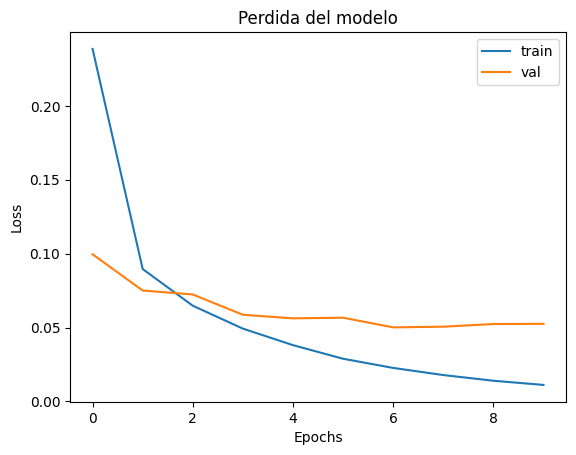

In [ ]:
### Visualización de las curvas de error
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdida del modelo')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

La gráfica de pérdida muestra una disminución rápida en train en las primeras epochs y continua decreciendo de manera gradual, por otro lado, la curva de validación obtiene cierta estabilidad pero mantiene una pérdida superior a los datos de entrenamiento, y así mismo, se observa cierta distancia considerable entre las curvas. Dicho esto, se llega a concluir que la red neuronal podría estar sobreajustada y requiere de manipulación en su arquitectura.

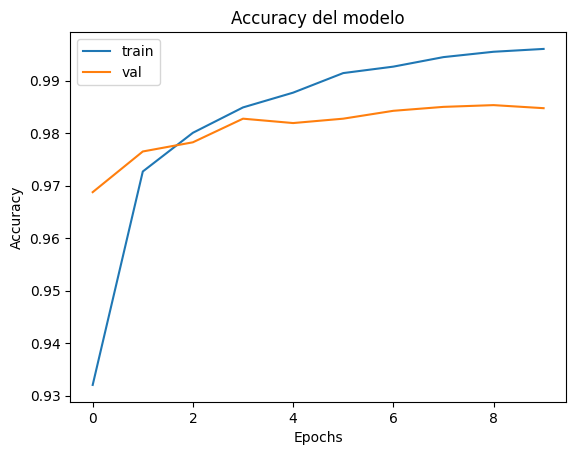

In [ ]:
### Visualización de las curvas de accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy del modelo')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

La gráfica muestra que la curva de train inicialmente se incrementa y continua exponencialmente, en comparación de la curva de validación, que aunque al principio demuestra incrementarse, esta luego tiende a estabilizarse, y la distancia entre las curvas corrobora el cierto grado de sobreajuste mencionado anteriormente.

In [ ]:
# Definición de las clases
class_name= ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

In [ ]:
# Predicción sobre el conjunto de datos
y_hat = np.argmax(model_cnn.predict(X_test_final), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
print(classification_report(y_test, y_hat, target_names=class_name))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.97      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



El classification report permite evidenciar numéricamente el sobreajuste mencionado, ya que se obtienen métricas realmente muy elevadas con una arquitectura realmente básica, llegando a obtener un accuracy del 99%.

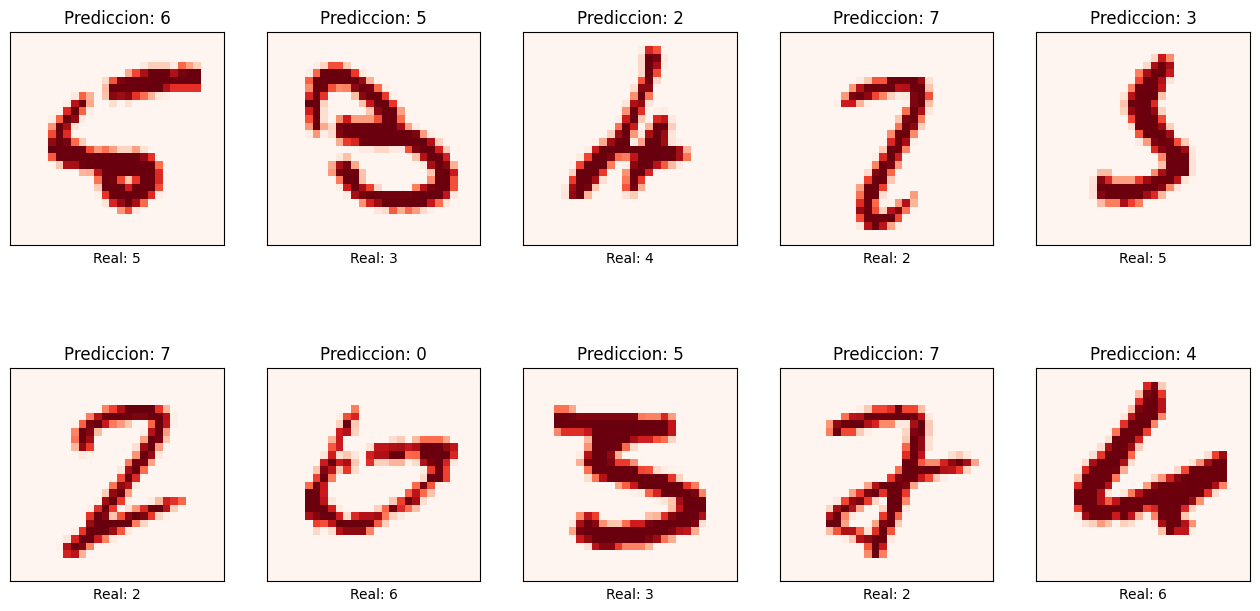

In [ ]:
errors = np.nonzero(y_hat != y_test)[0]
# Visualizar las primeras 10 predicciones erroneas
plt.figure(figsize=(16, 8))
for i, incorrect in enumerate(errors[0:10]):
    plt.subplot(2,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test_final[incorrect].reshape(28,28), cmap = 'Reds')
    plt.title("Prediccion: {}".format(class_name[y_hat[incorrect]]))
    plt.xlabel("Real: {}".format(class_name[y_test[incorrect]]))

En la primera red neuronal ejecutada podemos ver como a pesar de que la red neuronal ha aprendido a reconocer patrones en las imágenes, realiza predicciones incorrectas en sus datos de prueba por lo que se confirma el sobreajuste.

## **1.2. Modificación arquitectura de la red: Red neuronal con regularización L2**

En segundo lugar, y buscando disminuir el sobreajuste, se decide ejecutar otra red neuronal en la cual se realiza una modificación en la arquitectura de la misma agregando una regularización de tipo L2. La arquitectura de la red continúa siendo como la anterior pero se agrega el respectivo parámetro de regularización en la capa convolucional con una fuerza de regularización de 0.00001.

In [ ]:
## Definición de la arquitectura CNN
model_cnn_2 = keras.models.Sequential()

# Definición de la primera capa convolucional
model_cnn_2.add(keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    strides=(2, 2),
    activation='relu',
    kernel_regularizer=keras.regularizers.l2(0.00001),
    input_shape=(28, 28, 1)
)
)

# Definición de la capa de agrupación
model_cnn_2.add(
    keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(2,2)
    )
)

## La salida de la capa anterior es un tensor (vector) de 2D, Se debe convertir a 1D
# antes de pasar a las capas densas
model_cnn_2.add(
    keras.layers.Flatten()
)

## Adicion de las capas densas (totalmente conectadas) - Cabecera de clasificación
model_cnn_2.add(
    keras.layers.Dense(
        units=128,
        activation='relu'
    )
)

# Definición de capa de salida
model_cnn_2.add(
    keras.layers.Dense(
        units=10,
        activation='softmax'
    )
)

C:\Users\srest\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
## Compilación del modelo
model_cnn_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,194 (582.79 KB)

 Trainable params: 149,194 (582.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Entrenamiento de la Red Neuronal
history_2 = model_cnn_2.fit(
    X_train_final,
    y_train,
    epochs=10,
    #validation_data=(x_test2, y_test)
    validation_split=0.2
)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8601 - loss: 0.4774 - val_accuracy: 0.9708 - val_loss: 0.0991
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9731 - loss: 0.0909 - val_accuracy: 0.9762 - val_loss: 0.0739
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9808 - loss: 0.0613 - val_accuracy: 0.9797 - val_loss: 0.0651
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9856 - loss: 0.0488 - val_accuracy: 0.9776 - val_loss: 0.0722
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9889 - loss: 0.0353 - val_accuracy: 0.9802 - val_loss: 0.0661
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9920 - loss: 0.0276 - val_accuracy: 0.9831 - val_loss: 0.0521
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9935 - loss: 0.0209 - val_accuracy: 0.9842 - val_loss: 0.0538
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9945 - loss: 0.0

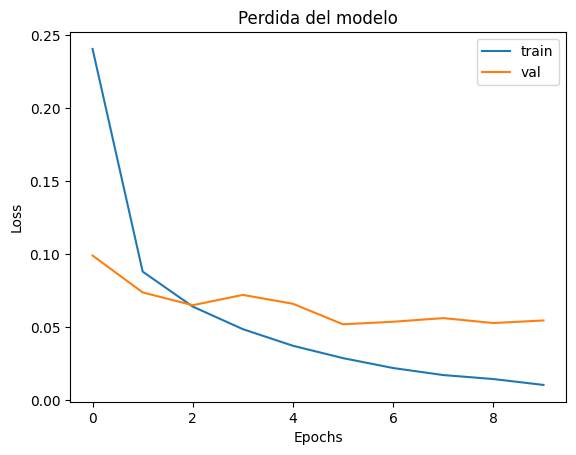

In [ ]:
### Visualización de las curvas de error
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Perdida del modelo')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

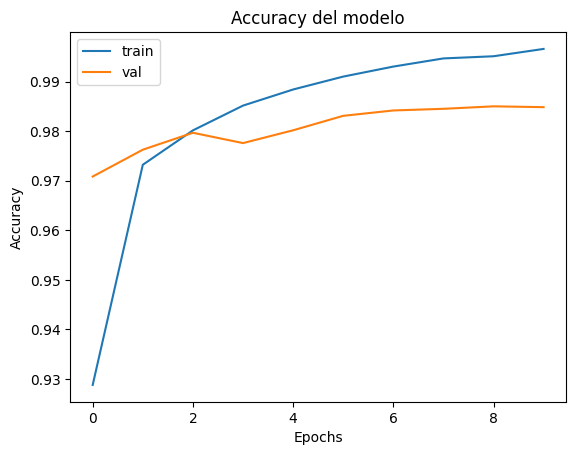

In [ ]:
### Visualización de las curvas de accuracy
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Accuracy del modelo')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

Las gráficas de périda y accuracy muestran un comportamiento realmente parecido a las arrojadas en la red neuronal anterior (red neuronal base), por lo que se concluye que esta red neuronal con regularización L2 sigue persiste en cierto grado de sobreajuste.

In [ ]:
# Predicción sobre el conjunto de datos
y_hat_2 = np.argmax(model_cnn_2.predict(X_test_final), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
print(classification_report(y_test, y_hat_2, target_names=class_name))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



De acuerdo con los resultados de las métricas, confirmamos que el modelo aún presenta signos de sobreajuste, y por ende, los datos se están ajustando de manera muy ideal (no generalizan).

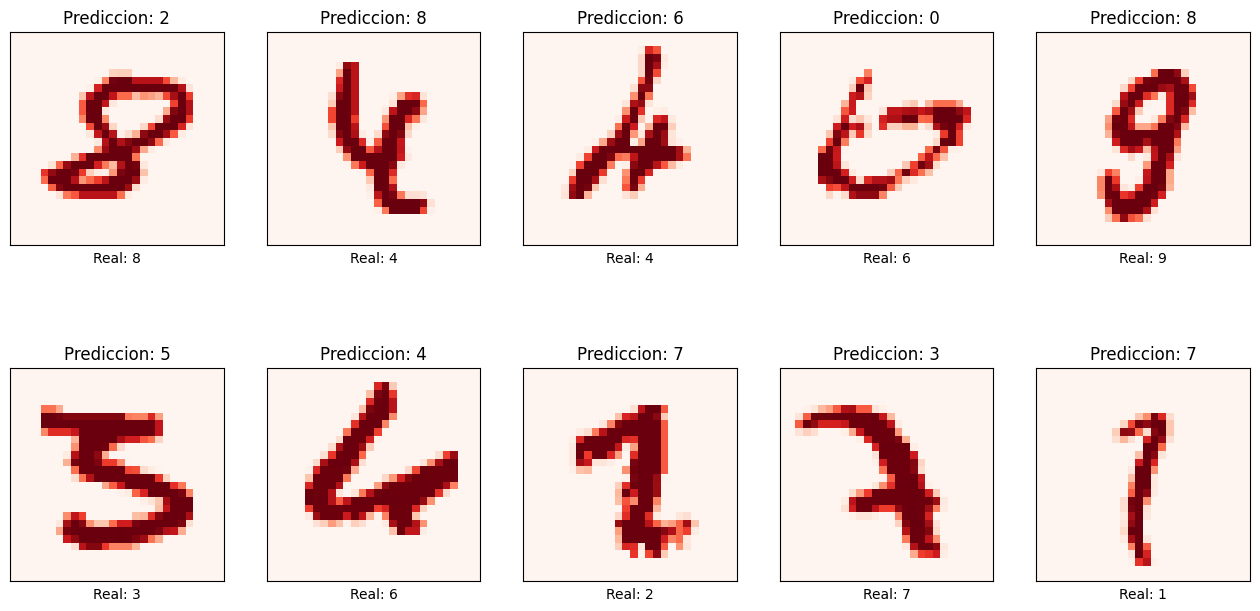

In [ ]:
errors = np.nonzero(y_hat_2 != y_test)[0]
# Visualizar las primeras 10 predicciones erroneas
plt.figure(figsize=(16, 8))
for i, incorrect in enumerate(errors[0:10]):
    plt.subplot(2,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test_final[incorrect].reshape(28,28), cmap = 'Reds')
    plt.title("Prediccion: {}".format(class_name[y_hat_2[incorrect]]))
    plt.xlabel("Real: {}".format(class_name[y_test[incorrect]]))

Se muestra que las predicciones de la red neuronal son bastante precisas para la mayoria de píxeles, continua reconociendo patrones pero aún hay algunas predicciones incorrectas.

## **1.3. Modificación arquitectura de la red: Red neuronal con regularización Dropout**

Se procede a realizar una tercera capa de la red neuronal (CNN) con una modificación en la arquitectura para incluir regularización de tipo Dropout. Para ello, se añade una capa de regularización dropout con una tasa de abandono del 25%

In [ ]:
# Definición de la arquitectura CNN con regularización Dropout
model_cnn_3 = tf.keras.Sequential([
    # Capa convolucional 1
    tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides=(2, 2),
        activation='relu',
        input_shape=(28, 28, 1)
    ),

    # Capa de agrupación 1
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2)
    ),

    # Aplanamiento de la salida de la capa convolucional
    tf.keras.layers.Flatten(),

    # Capa densa 1
    tf.keras.layers.Dense(
        units=32,
        activation='relu'
    ),

    # Capa de Dropout para regularización
    tf.keras.layers.Dropout(0.25),  # Dropout con tasa de abandono del 25%

    # Capa de salida
    tf.keras.layers.Dense(
        units=10,
        activation='softmax'
    )
])

C:\Users\srest\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
## Compilación del modelo
model_cnn_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,954 (74.04 KB)

 Trainable params: 18,954 (74.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Entrenamiento de la Red Neuronal
history_3 = model_cnn_3.fit(
    X_train_final,
    y_train,
    epochs=10,
    #validation_data=(x_test2, y_test)
    validation_split=0.2
)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7224 - loss: 0.8955 - val_accuracy: 0.9480 - val_loss: 0.1825
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9203 - loss: 0.2632 - val_accuracy: 0.9628 - val_loss: 0.1255
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9426 - loss: 0.1933 - val_accuracy: 0.9684 - val_loss: 0.1070
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9494 - loss: 0.1699 - val_accuracy: 0.9718 - val_loss: 0.0950
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9563 - loss: 0.1445 - val_accuracy: 0.9743 - val_loss: 0.0893
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9590 - loss: 0.1305 - val_accuracy: 0.9751 - val_loss: 0.0844
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9618 - loss: 0.1196 - val_accuracy: 0.9758 - val_loss: 0.0835
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9633 - loss: 0.1148 

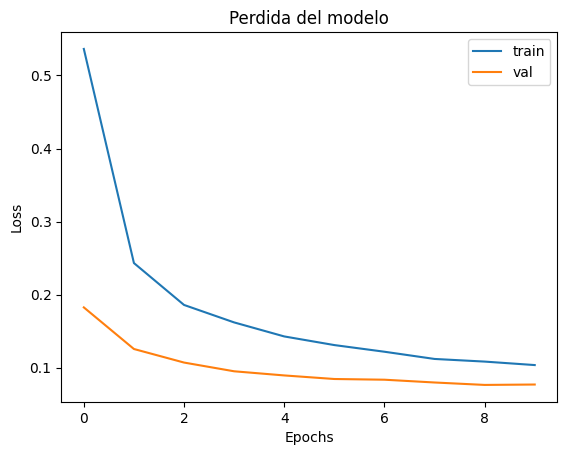

In [ ]:
### Visualización de las curvas de error
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Perdida del modelo')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

Se observa que ambas curvas de pérdida van disminuyendo, y en particular, la curva de pérdida de validación se estabiliza, por lo que el modelo ha alcanzado un punto donde no mejora significativamente con más entrenamiento. Dicho esto, se concluye que la regularización mediante Dropout implementada en la tercera capa de la red disminuye la pérdida, sin embargo se evidencia un comportamiento incoherente, dado que los datos de validación presentan una pérdida inferior a los datos de entrenamiento.

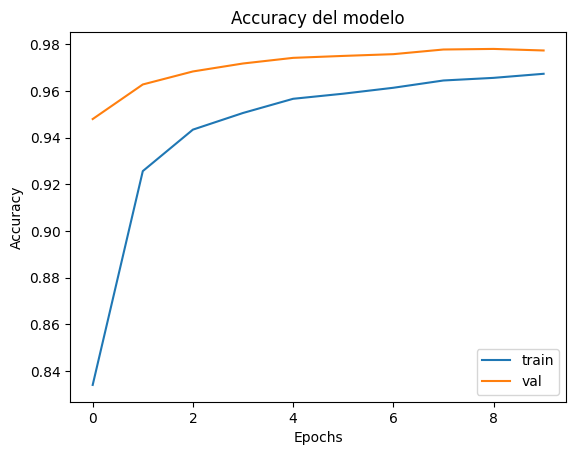

In [ ]:
### Visualización de las curvas de accuracy
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Accuracy del modelo')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

Así mismo, en cuanto a las curvas de accuracy se evidencia que el accuracy es superior en validación que en entrenamiento, lo que indica sobreajuste en la red neuronal.


In [ ]:
y_hat_3 = np.argmax(model_cnn_3.predict(X_test_final), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
print(classification_report(y_test, y_hat_3, target_names=class_name))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.97      0.98      0.97       892
           6       0.96      0.99      0.97       958
           7       0.98      0.96      0.97      1028
           8       0.98      0.96      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



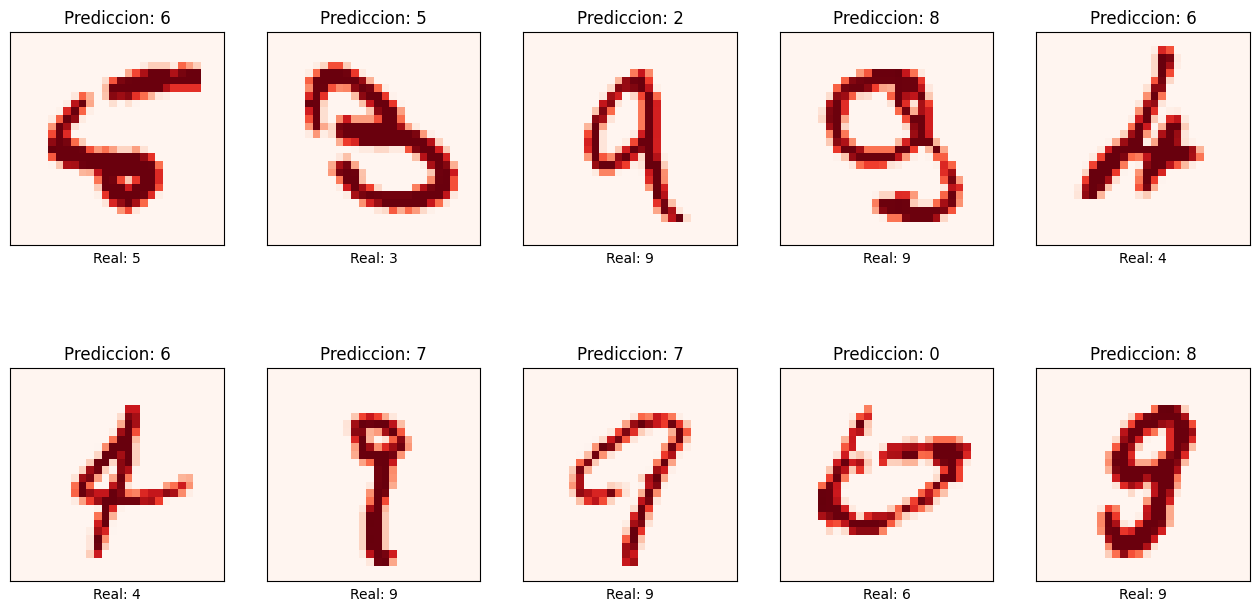

In [ ]:
errors = np.nonzero(y_hat_3 != y_test)[0]
# Visualizar las primeras 10 predicciones erroneas
plt.figure(figsize=(16, 8))
for i, incorrect in enumerate(errors[0:10]):
    plt.subplot(2,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test_final[incorrect].reshape(28,28), cmap = 'Reds')
    plt.title("Prediccion: {}".format(class_name[y_hat_3[incorrect]]))
    plt.xlabel("Real: {}".format(class_name[y_test[incorrect]]))

Una vez ejecutadas 3 redes neuronales convolucionales (red neuronal sin regularización, red neuronal con regularización L2 y red neuronal con regularización Dropout) se evidencia que todas presentan cierto grado de sobreajuste, dado que las gráficas de accuracy y pérdida del modelo lo demuestran, y sus métricas corroboran dicho comportamiento. Finalmente, sus grillas de imágenes demuestran que aún se obtienen ciertos errores de predicción en las redes neuronales en imágenes que son más detectables.

## **1.4. Red neuronal con optimización de hiperparámetros**

Ahora, para ejecutar la red neuronal con parámetros optimizados se decide montar una arquitectura contenida de la siguiente forma:
- 1 capa de entrada para las imágenes de 28x28 píxeles en escala de grises
- 2 capas convolucionales (2D) con sus respectivas capas de agrupación de tamaño 2x2
- 1 capa flatten (aplanamiento)
- 1 capa de Dropout
- 1 capa densa
- 1 capa de salida con sus respectivas 10 neuronas

Así mismo, pues cabe mencionar que los parámetros serán arrojados gracias al tunning realizado RandomSearch y que se compila la red con una función de pérdida de tipo *'sparse_categorical_crossentropy'* dado que se cuenta con un problema multiclase y un optimizador *'Nadam'* daod que puede ser más eficiente en algunas imágenes o datos ruidosos.

Finlamente, y como ya se observó, la métrica que se decide maximizar es el accuracy.

*Nota: se decide emplear esta arquitectura después de múltiples intentos y tanteo*

In [ ]:
def build_model(hp):
  model_tuned = tf.keras.Sequential()

  # Define the input layer for the image data
  model_tuned.add(keras.layers.Input(shape=(28, 28, 1)))

  # First convolutional layer with hyperparameter tuning for filters
  hp_filters_1 = hp.Int('filters_1', min_value=16, max_value=128, step=16)
  model_tuned.add(keras.layers.Conv2D(
      filters=hp_filters_1,
      kernel_size=(3, 3),
      activation='relu'))

  # Pooling layer
  model_tuned.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

  # Dropout layer with hyperparameter tuning for dropout rate
  hp_dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.05)
  model_tuned.add(keras.layers.Dropout(rate=hp_dropout_rate))

  # Second convolutional layer with hyperparameter tuning for filters
  hp_filters_2 = hp.Int('filters_2', min_value=16, max_value=128, step=16)
  model_tuned.add(keras.layers.Conv2D(
      filters=hp_filters_2,
      kernel_size=(3, 3),
      activation='relu'))

  # Pooling layer
  model_tuned.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  # Agragr otra capa convolucional y pooling o un L2

  # Flatten the output before feeding to dense layers
  model_tuned.add(keras.layers.Flatten())

  # First dense layer with hyperparameter tuning for units
  hp_unit_1 = hp.Int('unit_1', min_value=32, max_value=128, step=32)
  model_tuned.add(keras.layers.Dense(units=hp_unit_1, activation='relu'))

  # Second dense layer with hyperparameter tuning for units and activation
  #hp_activation_2 = hp.Choice('activation_2', values=['relu', 'tanh'])
  #hp_unit_2 = hp.Int('unit_2', min_value=32, max_value=256, step=32)
  #model_tuned.add(keras.layers.Dense(units=hp_unit_2, activation=hp_activation_2))

  # Output layer
  model_tuned.add(keras.layers.Dense(10, activation='softmax'))

  # Define the optimizer with hyperparameter tuning for learning rate
  hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001])

  model_tuned.compile(
      optimizer=tf.keras.optimizers.Nadam(learning_rate=hp_learning_rate),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

  return model_tuned

In [ ]:
### Definición del Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='results_tuner',
    project_name='Demo3'
)

In [ ]:
tuner.search(X_train_final, y_train, epochs=3, validation_data=(X_test_final, y_test))

Trial 5 Complete [00h 01m 47s]
val_accuracy: 0.9783999919891357

Best val_accuracy So Far: 0.9815999865531921
Total elapsed time: 00h 06m 39s


In [ ]:
tuner.get_best_hyperparameters()[0].get('dropout_rate')

0.15000000000000002

In [ ]:
tuner.get_best_hyperparameters()[0].get('learning_rate')

0.0001

In [ ]:
### Almacenar el mejor modelo
best_model = tuner.get_best_models()[0]
### Definir la arquitectura del modelo según hiperparámetros optimos
#best_model.build(X_train_final.shape)
### Resumen de la arquitectura
best_model.summary()

C:\Users\srest\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 19 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 112)    │        16,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │       268,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,266 (1.09 MB)

 Trainable params: 286,266 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### Ajuste de la red neuronal con hiperparámetros optimos
history_4 = best_model.fit(X_train_final, y_train, epochs=7, validation_data = (X_test_final, y_test))

### Cual es el epoch con max val_accuracy
val_accuracy_per_epoch = history_4.history['val_accuracy']
best_epoch = val_accuracy_per_epoch.index(max(val_accuracy_per_epoch))+1
print(f"Best epoch: {best_epoch}")

Epoch 1/7
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9794 - loss: 0.0704 - val_accuracy: 0.9835 - val_loss: 0.0500
Epoch 2/7
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9821 - loss: 0.0606 - val_accuracy: 0.9841 - val_loss: 0.0507
Epoch 3/7
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - accuracy: 0.9841 - loss: 0.0530 - val_accuracy: 0.9855 - val_loss: 0.0410
Epoch 4/7
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9862 - loss: 0.0468 - val_accuracy: 0.9865 - val_loss: 0.0417
Epoch 5/7
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9875 - loss: 0.0423 - val_accuracy: 0.9885 - val_loss: 0.0344
Epoch 6/7
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9887 - loss: 0.0378 - val_accuracy: 0.9891 - val_loss: 0.0363
Epoch 7/7
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9885 - loss: 0.0374 - val_accuracy: 0.9876 - val_loss: 0.0347
Best epoch: 6


Gracias al ajuste realizado para la red neuronal se observa que la pérdida del modelo se va reduciendo a medida que aumentan las epochs, así mismo, su accuracy tiende a crecer a medida que se ejecutan más epochs tanto en train como en validación. Esto, nos da a entender que si se aumentan las epochs se podría llegar a obtener una ccuracy mayor y una pérdida inferior, sin embargo, el tiempo de procesamiento se aumenta notablemente.

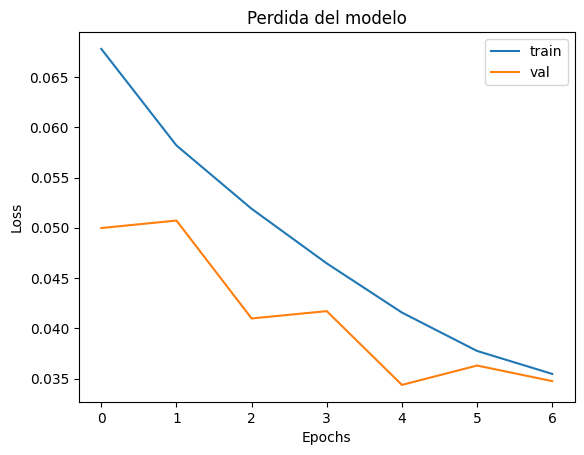

In [ ]:
### Visualización de las curvas de error
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Perdida del modelo')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

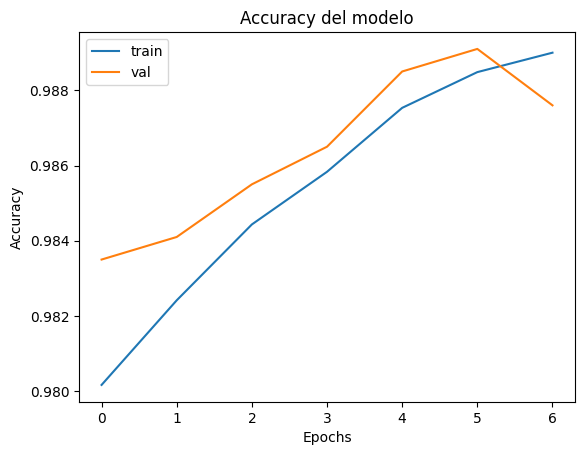

In [ ]:
### Visualización de las curvas de accuracy
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Accuracy del modelo')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

Finalmente, gracias a las gráficas se evidencia un comportamiento mucho más coherente y adecuado después de optimizar hiperparámetros.
En el caso de la gráfica de pérdida se evidencia que ambas curvas convergen y son realmente cercanas por lo que la red neuronal desempeña un comportamiento parecido tanto en train como en test. Por otro lado, a pesar de que la gráfica de accuracy parece presentar un comportamiento similar a las redes neuronales ejecutadas anteriormente, la red neuronal optimizada obtiene accuracy similar tanto en train como en test (note que la escala en el eje Y es diferente en esta gráfica que en las demás) y que además, después de la 5ta epoch train obtiene un accuracy ligeramente superior a test (lo que demuestra un comportamiento coherente por parte de la red neuronal).

In [ ]:
y_hat_4 = np.argmax(best_model.predict(X_test_final), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [ ]:
print(classification_report(y_test, y_hat_4, target_names=class_name))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.97      0.98      1032
           3       0.97      1.00      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



Las métricas de test son realmente buenas, lo que permite concluir que esta red neuronal convolucional con parámetros optimizados no presenta sobreajuste (como se concluyó anteriormente) y por ende, es la red neuronal óptima en el proyecto.

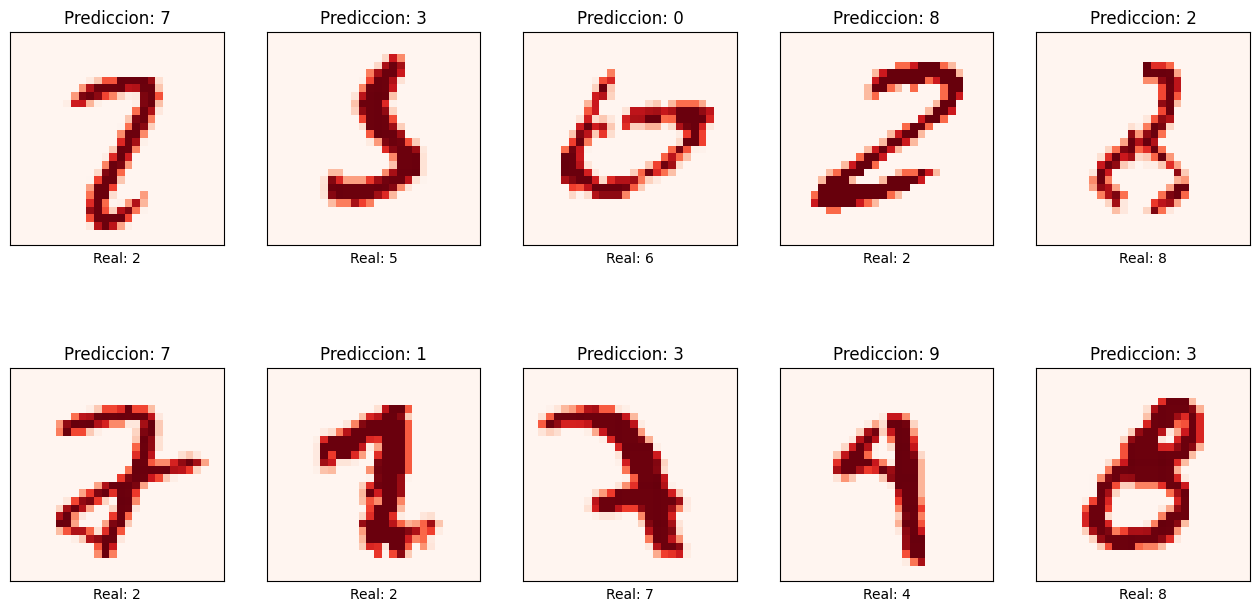

In [ ]:
errors = np.nonzero(y_hat_4 != y_test)[0]
# Visualizar las primeras 10 predicciones erroneas
plt.figure(figsize=(16, 8))
for i, incorrect in enumerate(errors[0:10]):
    plt.subplot(2,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test_final[incorrect].reshape(28,28), cmap = 'Reds')
    plt.title("Prediccion: {}".format(class_name[y_hat_4[incorrect]]))
    plt.xlabel("Real: {}".format(class_name[y_test[incorrect]]))

In [ ]:
### Utilizar el metodo evaluate para evaluar la red neuronal
test_loss, test_accuracy = best_model.evaluate(X_test_final, y_test)
print('Test accuracy: ', test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9849 - loss: 0.0424
Test accuracy:  0.9876000285148621


**Conclusión general de redes neuronales convolucionales**

Una vez ejecutada la red neuronal con optimización de hiperparámetros encontramos que esta ha sido la red que mejor rendimiento ha arrojado, dado que a diferencia de las redes neuronales anteriormente ejecutadas, en esta ('*best_model*') las rectas tanto de pérdida como de accuracy tienden a converger, y adicionalmente, se observa que el accuracy en train es mayor que el accuracy de validación a partir de la 5ta epoch. Por otro lado, en la grilla de predicciones se observa que el modelo presenta errores de predicción con imágenes que son realmente confusas o complicadas de detectar. Dicho esto, se concluye que esta red neuronal no presenta sobreajuste y sus métricas de desempeño (ver 'classification_report') son realmente buenas, por ende, esta red neuronal es la mejor que se obtuvo a lo largo del proyecto.

Ahora, se procede al montaje de un modelo de shallow learning para contrastar los resultados de este con los resultados de nuestra red neuronal óptima. Para ello, se decide ejecutar un modelo de Random Forest dado que a lo largo de nuestra experiencia con modelos de aprendizaje supervisado ha sido el tipo de modelo que nos ha arrojado los mejores resultados.

# **2. Modelo de shallow learning**

## **2.1. Random Forest**

In [4]:
# Convertir las imagenes de train y test en vectores unidimensionales
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [5]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_flat, y_train)

RandomForestClassifier()

In [6]:
y_pred_train = rf_model.predict(X_train_flat)
y_pred = rf_model.predict(X_test_flat)
accuracy = accuracy_score(y_test, y_pred)

In [7]:
print(metrics.classification_report(y_train, y_pred_train)) #métricas en entrenamiento

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       1.00      1.00      1.00      6742
           2       1.00      1.00      1.00      5958
           3       1.00      1.00      1.00      6131
           4       1.00      1.00      1.00      5842
           5       1.00      1.00      1.00      5421
           6       1.00      1.00      1.00      5918
           7       1.00      1.00      1.00      6265
           8       1.00      1.00      1.00      5851
           9       1.00      1.00      1.00      5949

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



In [8]:
print(metrics.classification_report(y_test, y_pred)) #métricas en test

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Una vez ejecutado el modelo Random Forest se encuentra la presencia de sobreajuste sobre el modelo dado que las métricas en train son 100% en su totalidad, y además, las métricas en test son muy cercanas al 100% (con un accuracy de 97%) lo que permite concluir que el modelo requiere de la optimización de hiperparámetros para obtener resultados mucho más coherentes.

## **2.2. Random Forest con optimización de hiperparámetros**

In [10]:
# Identificación de parametros de optimización

print("+----------------------\nModelo - RandomForest:")
pprint.pprint(rf_model.get_params())

+----------------------
Modelo - RandomForest:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [11]:
# Definición de los parámetros para la búsqueda aleatoria
params = {
    'bootstrap': [True, False],
    'n_estimators': [20, 50], # Aumenta la granularidad de n_estimators
    'class_weight': ['balanced', None],
    'max_depth': [3, 5, None], # Aumenta la granularidad de max_depth
    'min_samples_split': [5, 10, 50],
    'max_features': ['sqrt', 'log2', 'auto', None], # Se incluyen nuevas opciones para max_features
    'n_jobs': [-1],
    'random_state': [42] # Se fija la semilla aleatoria para la reproducibilidad
}

In [12]:
# Búsqueda aleatoria

# Definición de cuadricula de búsqueda
rand_rf = RandomizedSearchCV(rf_model, param_distributions=params) #¿verbose=True)?

# Iniciar la búsqueda
rand_rf.fit(X_train_flat, y_train)

C:\Users\srest\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\srest\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\srest\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packag

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None],
                                        'max_depth': [3, 5, None],
                                        'max_features': ['sqrt', 'log2', 'auto',
                                                         None],
                                        'min_samples_split': [5, 10, 50],
                                        'n_estimators': [20, 50],
                                        'n_jobs': [-1], 'random_state': [42]})

In [13]:
print('Mejores Hiperparámetros: ', rand_rf.best_params_)
print('Mejor Score: ', rand_rf.best_score_)

Mejores Hiperparámetros:  {'random_state': 42, 'n_jobs': -1, 'n_estimators': 50, 'min_samples_split': 50, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': True}
Mejor Score:  0.9514833333333333


In [14]:
# Métricas de desempeño modelo óptimo
# ==============================================================================
rf_optimo = rand_rf.best_estimator_
print ("Train - Accuracy :", metrics.accuracy_score(y_train, rf_optimo.predict(X_train_flat)))
print ("Train - classification report :", metrics.classification_report(y_train, rf_optimo.predict(X_train_flat)))


Train - Accuracy : 0.9766666666666667
Train - classification report :               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5923
           1       0.99      0.98      0.99      6742
           2       0.97      0.98      0.97      5958
           3       0.97      0.96      0.97      6131
           4       0.98      0.98      0.98      5842
           5       0.98      0.98      0.98      5421
           6       0.98      0.99      0.99      5918
           7       0.98      0.97      0.98      6265
           8       0.96      0.97      0.97      5851
           9       0.97      0.96      0.96      5949

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



In [15]:
print ("Test - Accuracy :", metrics.accuracy_score(y_test, rf_optimo.predict(X_test_flat)))
print ("Test - classification report :", metrics.classification_report(y_test, rf_optimo.predict(X_test_flat)))

Test - Accuracy : 0.9573
Test - classification report :               precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.99      0.98      0.99      1135
           2       0.94      0.95      0.95      1032
           3       0.95      0.93      0.94      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.95      0.96       892
           6       0.96      0.97      0.97       958
           7       0.96      0.95      0.95      1028
           8       0.93      0.94      0.94       974
           9       0.94      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



Gracias al classification report, se observa que las métricas de train son muy buenas y ya no son del 100%, por ende se puede concluir que el modelo Random Forest ya no presenta sobreajuste después de la optimización de hiperparámetros. Así mismo, las métricas en test también son buenas (y son inferiores a las de train), obteniendo un accuaracy de 95,73%. 

### **Matriz de confusión Random Forest**

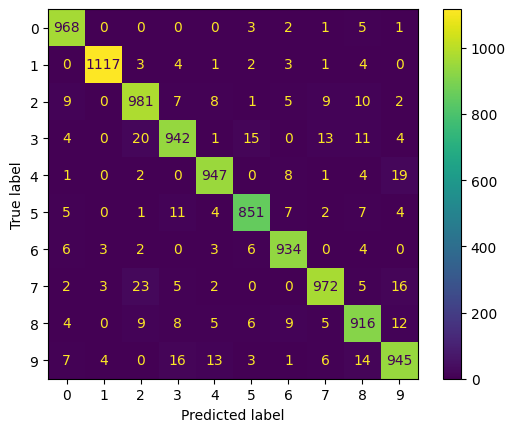

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Matriz de confusion
cm= confusion_matrix(y_test, rf_optimo.predict(X_test_flat))
# Visualización de la matriz de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

En la matriz de confusión se observa que los valores en la diagonal son bastante altos, lo que indica que el modelo predice correctamente la mayoría de los dígitos. Por otro lado, hay ciertos dígitos que el modelo confunde con mayor frecuencia. Por ejemplo, el dígito '4' es clasificado incorrectamente como '9' en 19 ocasiones, lo que sugiere que el modelo confunde estos dos dígitos con relativa frecuencia. Además, el modelo tiene dificultades para distinguir entre otro números, ya que se presentan confusiones al momento de predecir el número '9' ya que lo clasifica en varias ocasiones como '3' (16 veces), '4' (13 veces) y '8' (14 veces), además, el modelo presenta una leve dificultad para diferenciar entre los números '2', '3', '7' y '8', sin embargo, las predicciones del modelo son realmente acertadas.

## **Conclusiones y recomendaciones**

- El modelo de red neuronal convolucional con parámetros optimizados es la red neuronal más óptima, con una precisión de test del 98.76% y mostró buen comportamiento en términos de convergencia, evitando el sobreajuste y aunque se observan algunos errores en la clasificación de los dígitos, la red demuestra ser mas robusta y precisa en su mayoría.

- Por otro lado, el modelo de Random Forest con optimización de hiperparametros tabién muestra buenos resultados, con un accuracy del 95,73%. 

- Ahora bien, la red neuronal convolucional con párametros optimizados supera al Random Forest en terminos de accuracy de test, es decir, la red neuronal convolucional óptima tiene una capacidad ligeramente mayor para predecir nuevos datos.

- En cuanto al reconocimiento de dígitos, la red neuronal generalmente acierta la mayoría de los dígitos, con pocos errores al igual que el Random Forest, pero este tiende a confundir ciertos dígitos con mas frecuencia, lo cual se evidencia en la matríz de confusión, por lo que la red neuronal es la opción mas adecuada para el problema que enfrenta la empresa sobre la dígitalización de formularios.

- Ambos modelos presentan dificultades ciertas (leves) dificultades para predecir el valor de números que llegan a ser parecidos como el '3' con el '8' o el '2' con el '7'.

- El conjunto de datos parece ser sencillo y procesable tanto para las redes nueronales convolucionales como para el Random Forest ya que arrojan métricas de desempeño realmente buenas.

- Finalmente se recomienda a la empresa realizar pruebas exhaustivas respecto a los dígitos reales antes de la implementación final para asegurar fiabilidad del sistema a implementar, además de continuar explorando la arquitectura de la red neuronal para mejorar aún mas la precisión con capacidades computacionales superiores.